# TP2 : Estimation de densité par noyaux

## Introduction à l'estimation statistique - G3 SDIA

Dans le cadre de cours, nous avons étudié jusqu'à présent des méthodes d'estimation dites paramétriques : on se fixe une famille de lois paramétrique à laquelle la loi ayant généré les données est censée appartenir, puis on cherche à estimer les paramètres à partir des données (par exemple par maximum de vraisemblance).

Dans ce TP, nous introduisons une méthode d'estimation **non-paramétrique** de la fonction de densité appelée estimation par noyaux (*kernel estimation* en anglais). C'est-à-dire que nous ne faisons plus d'hypothèse sur la loi ayant généré les données, et nous cherchons plutôt à estimer directement la densité de la loi parente $f$ (que l'on supposera continue). Ainsi cette méthode ne concerne que les variables aléatoires continues.

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 22 Octobre 2023, 23h59.

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Partie 1 - Histogrammes

On considère $(x_1, ..., x_n)$ $n$ réalisations indépendantes d'une variable aléatoire réelle.

Soit $x_0 \in \mathbb{R}$ et $h > 0$. On partitionne la droite réelle en intervalles de même longueur $h$, aussi appelés *bins* :
$$\forall k \in \mathbb{Z},~B_k =~]x_0 + (k-1)h~;~x_0 + kh].$$

L'histogramme est une fonction constante par morceaux définie de la manière suivante :
$$\forall x \in B_k,~H_n(x) = n_k,$$
où $n_k$ est le nombre de réalisations appartenant à l'intervalle $B_k$.

**Q1**. Comment normaliser $H_n$ pour obtenir un estimateur de la fonction de densité ? On rappelera que $\int_{\mathbb{R}} f(x) dx = 1$.

Dans la suite, on note $\hat{f}_n$ cet estimateur de $f$.

Pour tout $x \in \mathbb{R}$, calculer le biais et la variance de $\hat{f}_n(x)$. Commenter.


----- Votre réponse ici -----

**Q2**. On fixe $x_0 = \min_i x_i$. La valeur de $h$ peut être fixée indirectement en fixant à la place le nombre de *bins* $N_b$ entre $\min_i x_i$ et $\max_i x_i$, on a alors
$$h = \frac{\max_i x_i - \min_i x_i}{N_b}.$$

Générer 200 points d'un modèle de mélange gaussien à 2 composantes avec $\mu_1 = -2.5, \mu_2 = 1.5, \sigma_1 = \sigma_2 = 1, \pi_1 = 0.4, \pi_2 = 0.6$.

Montrer l'influence de la valeur de $h$ sur l'histogramme (normalisé). On utilisera la fonction $\texttt{np.histogram}$ pour calculer automatiquement les $n_k$, et la fonction $\texttt{plt.bar}$ pour représenter $\hat{f}_n$. Superposer la densité théorique du modèle de mélange gaussien.

On pourra afficher plusieurs histogrammes obtenus avec différentes valeurs de $N_b$ à l'aide de $\texttt{plt.subplots}$. Commenter.

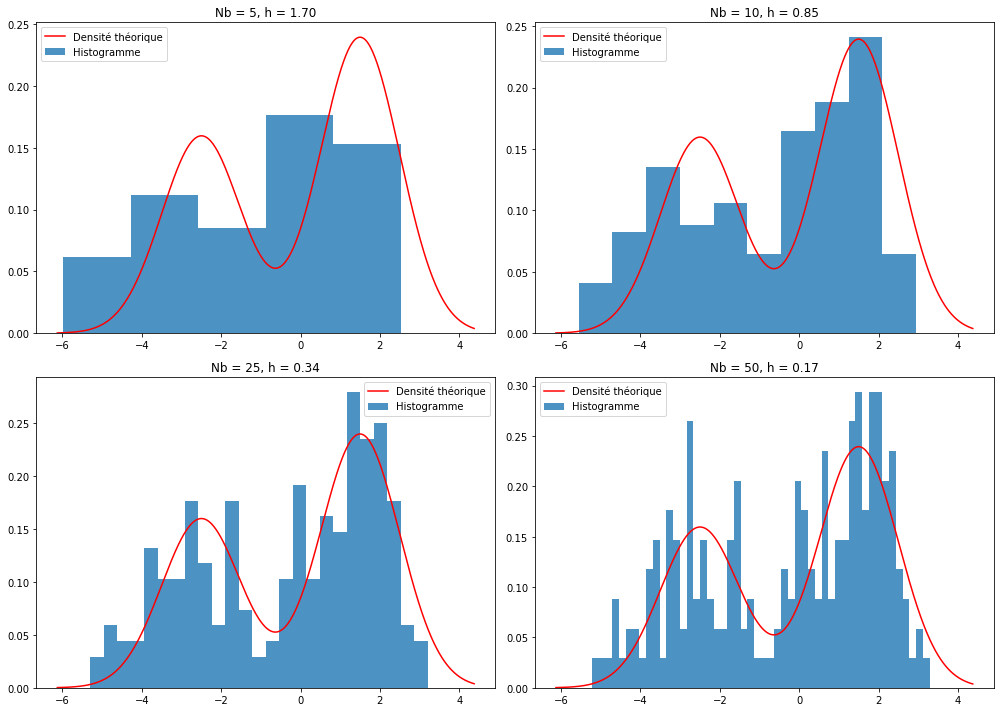

In [7]:
# Generate data from GMM

N = 200

# Paramètres du modèle de mélange gaussien
mu1, mu2 = -2.5, 1.5
sigma1, sigma2 = 1, 1
pi1, pi2 = 0.4, 0.6

N1 = int(N * pi1) #80
N2 = N - N1       #120

samples1 = np.random.normal(mu1, sigma1, N1)
samples2 = np.random.normal(mu2, sigma2, N2)
samples = np.concatenate([samples1, samples2])

#print(samples)


# Plot histograms with varying number of bins

Nb_values = [5, 10, 25, 50]

def mixture_density(x, mu1, mu2, sigma1, sigma2, pi1, pi2):
    return pi1 * (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1)**2) + \
           pi2 * (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2)**2)


x_values = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
y_values = mixture_density(x_values, mu1, mu2, sigma1, sigma2, pi1, pi2)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, Nb in zip(axes, Nb_values):
    h = (samples.max() - samples.min()) / Nb # taille de l'intervalle
    
    hist, bins = np.histogram(samples, bins=Nb, density=True)
    bin_widths = np.diff(bins)
    ax.bar(bins[:-1], hist, width=bin_widths, alpha=0.8, label='Histogramme')
    ax.plot(x_values, y_values, 'r-', label='Densité théorique')
    ax.set_title(f'Nb = {Nb}, h = {h:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()



> On remarque que la largeur des bins (h) influence grandement la forme de l'histogramme.
>
> Une grande valeur de $h$ lisse la distribution, omettant des détails, tandis qu'une petite valeure de $h$ introduit du bruit avec une apparence plus découpé. Il semblerait que $h$ soit le paramètre de lissage de notre histogramme.  
>
> Un $h$ autour de la valeur obtenue pour $N_b$ $\approx$ $20$ semble optimale pour cet échantillon, capturant fidèlement la structure tout en minimisant le bruit.

**Q3**. Quelles sont les principales limitations de l'utilisation de l'histogramme comme estimateur de la fonction de densité ?

> Tout d'abord, nous avons vu que l'histogramme, en tant qu'estimateur de la fonction de densité, était sensible à la taille des bins (h). De légères variations de $h$ peuvent impacter sa forme et sa précision et peuvent soit lisser des détails importants, soit introduire du bruit.
>
> L'histogramme donne une estimation discrète et non continue de la fonction de densité. Cette nature discrète peut introduire des "discontinuités artificielles" (sauts abrupts) et ne reflétant pas fidèlement la distribution continue des données sous-jacentes.
>
> Donc l'histogramme ne semble pas être une méthode précise pour estimer une fonction de densité.

### Partie 2 - Estimation par noyaux (en 1D)

$(x_1, ..., x_n)$ sont toujours $n$ réalisations indépendantes d'une variable aléatoire réelle.

L'une des motivations principales est de faire directement dépendre l'estimation des données, et de ne plus dépendre de découpages arbitraires de $\mathbb{R}$. Pour cela, on propose la méthodologie suivante :
- Choisir une fonction $K$ appelée "noyau". On choisit $K$ positive ou nulle, symétrique, et d'intégrale 1.
- Centrer $K$ sur chaque observation $x_i$.
- L'estimateur à noyaux est alors
$$\hat{f}_n(x) = \frac{1}{n} \sum_{i=1}^n K(x - x_i).$$

On pourra par exemple choisir des noyaux $K$ continus, dérivables partout... Propriétés dont $\hat{f}_n$ héritera.

**Q1**. On utilise dans un premier temps un noyau gaussien :
$$K(x) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{x^2}{2}).$$

Prendre 10 observations des données générées dans la partie 1. Sur un même graphique, représenter les 10 noyaux (normalisés par $n$) centrés sur les observations, et l'estimateur à noyaux $\hat{f}_n$. Superposer la vraie densité $f$. Commenter.

[ 2.73441607  1.60402144  1.46560218 -2.54466487  1.75107929 -2.60150089
  2.22162219 -1.70236062 -1.43528904  0.92875482]


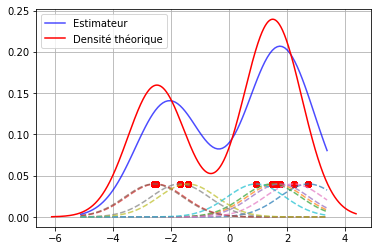

In [8]:
# Randomly select 10 points from previously generated dataset

x_select=np.random.choice(samples,10, replace=False)
print(x_select)

def fn(x):
    l=[]
    for xk in x_select:
        l.append(1/np.sqrt(2*np.pi)*np.exp(-np.square(x-xk)/2)*1/len(x_select))
    return np.array(l)

X_long = np.linspace(samples.min(), samples.max(), 100) 
Y_long=fn(X_long)
for i in range(len(Y_long)):
    Z=Y_long[i]
    plt.plot(X_long, Z, '--', alpha=0.7)

    plt.scatter(x_select, [1/np.sqrt(2*np.pi)*1/len(x_select)]*len(x_select), c='r')
plt.plot(X_long, Y_long.sum(axis=0),'b-',  alpha=0.7,label='Estimateur')
plt.plot(x_values, y_values, 'r-', label='Densité théorique')
plt.legend()
plt.grid(True)

plt.show()



> Chaque noyau gaussien (courbe en pointillés) apporte une contribution locale à l'estimation globale de la densité. L'agrégation de ces contributions locales produit $f_n$, qui est une approximation lisse de la vraie densité.
>
> L'estimateur par noyaux fournit une estimation lisse et continue de la densité, sans les "interruptions induites" que nous avions avec les histogrammes.
>
> La superposition de la densité réelle montre que l'estimateur par noyaux est capable de capturer la structure générale de la distribution, même avec un petit échantillon. Cependant, avec davantage d'observations, l'estimation serait plus précise et se rapprocherait davantage de la densité réelle.

**Q2**. En réalité, on souhaite faire dépendre cet estimateur d'un paramètre de lissage $h > 0$, qu'on appelle largeur de fenêtre (ou *bandwidth* en anglais).

Le (véritable) estimateur à noyaux, aussi appelé méthode de Parzen-Rosenblatt (du nom des deux statisticiens l'ayant développée) est :
$$\hat{f}_n(x) = \frac{1}{nh} \sum_{i=1}^n K(\frac{x - x_i}{h}).$$

Vérifier que c'est bien l'estimateur d'une densité.

Implémenter cet estimateur sur les données de la partie 1, et montrer l'influence de la valeur de $h$. On pourra encore utiliser $\texttt{plt.subplots}$. Commenter.

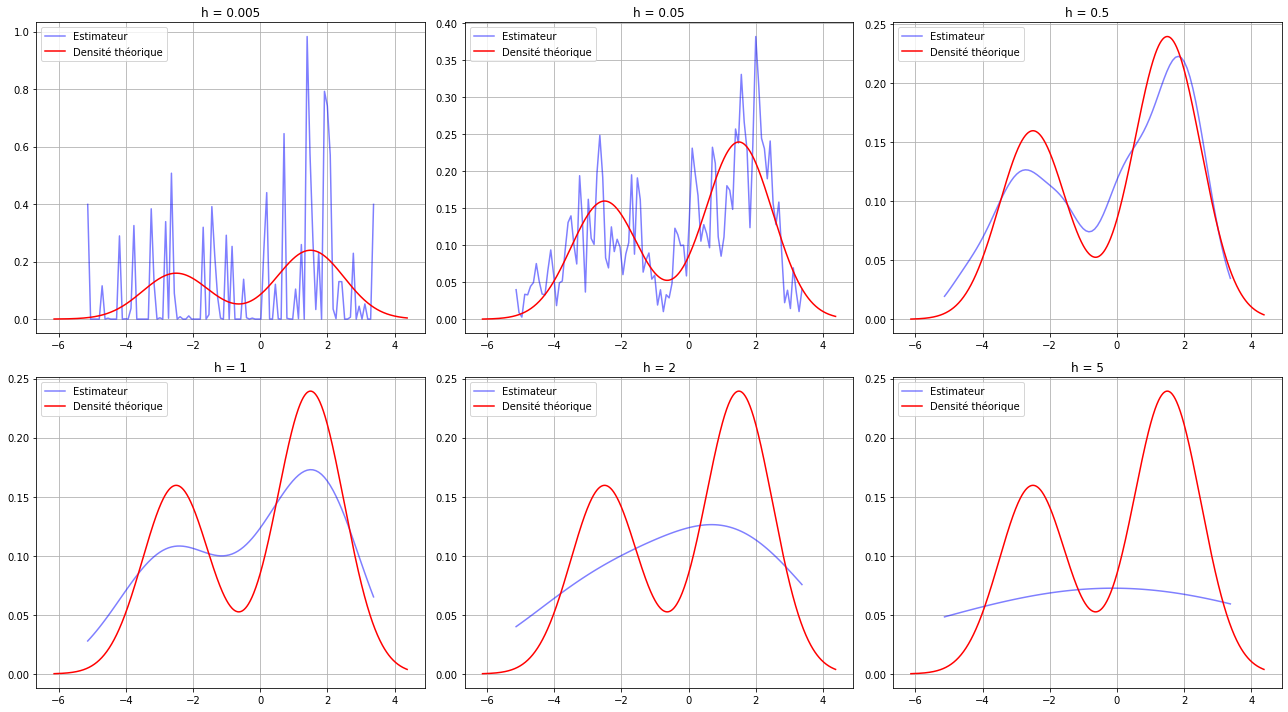

In [9]:
# Randomly select 10 points from previously generated dataset

def fn2(x,h):
    l=[]
    for xk in samples:
        l.append(1/np.sqrt(2*np.pi)*np.exp(-np.square((x-xk)/h)/2)*1/(len(samples)*h))
    return np.array(l)

H=[0.005,0.05,0.5,1,2,5]

#Affichage
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for ax, h in zip(axes.ravel(), H):
    X_long = np.linspace(samples.min(), samples.max(), 100) 
    Y_long=fn2(X_long,h)
    ax.plot(X_long, Y_long.sum(axis=0),'b-',  alpha=0.5,label='Estimateur')
    ax.plot(x_values, y_values, 'r-', label='Densité théorique')
    ax.set_title(f"h = {h}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



> Encore une fois, on remarque que le choix de $h$ est crucial pour l'estimation par noyaux. On peut voir que plus h augmente, plus la courbe d'estimation se lisse, cependant au delà d'un certain seuil, ce lissage devient trop fort et l'on tend vers une constante. Une valeur trop petite peut quant à elle, introduire trop de bruit. 
>
> Il faut trouver le bon compromis pour $h$ pour obtenir une estimation qui capture fidèlement la structure des données tout en minimisant le bruit.

**Q3.** Nous allons maintenant regarder d'autres noyaux. Cette fois-ci, nous n'implémenterons pas l'estimateur à la main mais ferons appel à la librairie `scikit-learn` qui implémente six noyaux différents (dont le noyau gaussien). La méthode est implémentée dans `sklearn.neighbors.KernelDensity`.

Représenter les six noyaux. Commenter.

À longueur de fenêtre fixée (par exemple $h = 0.5$), montrer l'influence des différentes fenêtres. On pourra encore utiliser $\texttt{plt.subplots}$. Commenter.

In [10]:
from sklearn.neighbors import KernelDensity

Text(0.5, 1.0, 'Available Kernels')

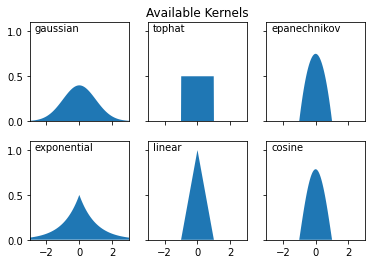

In [11]:

# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)

for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens))
    axi.text(-2.7, 1, kernel)
    axi.set_ylim(0, 1.1)
    axi.set_xlim(-3, 3)

ax[0, 1].set_title("Available Kernels")


> Chaque noyau a sa propre caractéristique en termes de répartition du poids autour de son centre. Comme leurs noms l'indique : 
>> * Gaussian : ressemble à une distribution normale. 
>> * Top-hat : ressemble à un rectangle. Il donne un poids égal à toutes les observations dans une certaine fenêtre et un poids nul ailleurs.
>> * Epanechnikov : attribue un poids décroissant à mesure que l'on s'éloigne de son centre. 
>> * Exponential :  décroît exponentiellement à partir de son centre.
>> * Linear : diminue linéairement à partir de son centre.
>> * Cosine : a la forme d'un demi-cosinus sur une fenêtre.
>
> Donc Le choix du noyau influence la manière dont l'estimation par noyaux attribue des poids aux observations voisines.

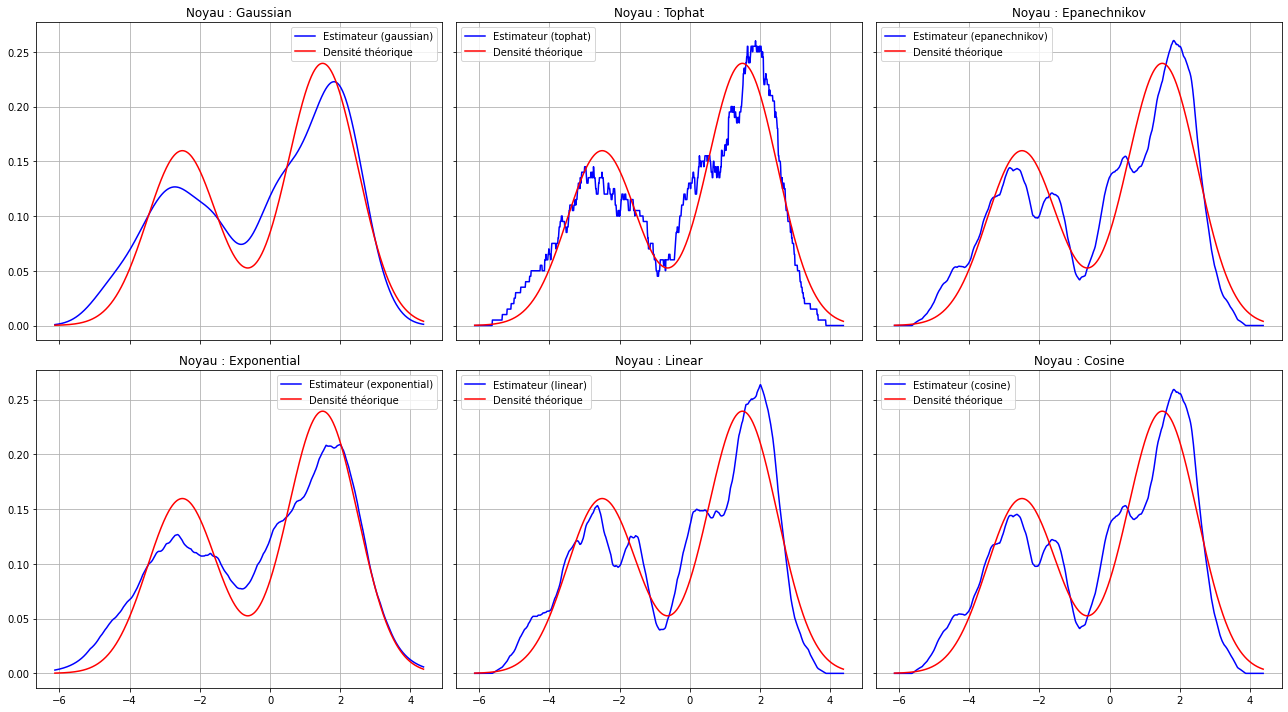

In [12]:

kernels=['gaussian','tophat','epanechnikov','exponential','linear','cosine']
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
#représente les six noyaux différents implémentés dans scikit-learn.neighbors.kernel_density

for ax, kernel in zip(axes.ravel(), kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(samples.reshape(-1, 1))
    log_dens = kde.score_samples(x_values.reshape(-1, 1))
    ax.plot(x_values, np.exp(log_dens), 'b-', label=f'Estimateur ({kernel})')
    ax.plot(x_values, y_values, 'r-', label='Densité théorique')
    ax.set_title(f"Noyau : {kernel.capitalize()}")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show();

> * Gaussien : Donne une estimation lisse qui suit de près la densité théorique.
> * Top-hat : L'estimation est plus rugueuse par rapport au noyau gaussien. Elle ressemble à une série d'histogrammes adjacents. C'est une estimation par morceaux, mais elle capture plutot correctement la structure globale des données.
> * Epanechnikov : L'estimation est assez lisse (un peu plus que la Top-hat) et suit bien la densité théorique.
> * Exponentiel : Donne une estimation avec des queues plus longues. Il attribue plus de poids aux observations éloignées par rapport à d'autres noyaux.
> * Linéaire : Donne également une estimation lisse, mais avec quelques irrégularités. Elle se situe entre le top-hat et le gaussien en termes de lissage.
> * Cosine : L'estimation est également lisse et se rapproche de la densité théorique, avec une décroissance en forme de cosinus à partir des points d'échantillon.

In [13]:
import plotly.graph_objects as go

# Préparation des données pour la visualisation avec plotly
traces = []

# Estimations pour chaque noyau
for kernel in kernels:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(samples.reshape(-1, 1))
    log_dens = kde.score_samples(x_values.reshape(-1, 1))
    traces.append(go.Scatter(x=x_values, y=np.exp(log_dens), mode='lines', name=f'KDE - Noyau {kernel}'))

# Densité théorique
traces.append(go.Scatter(x=x_values, y=y_values, mode='lines', name='Densité théorique', line=dict(width=4, color="red")))

# Construction du graphique
layout = go.Layout(title="Comparaison des estimations de densité avec différents noyaux",
                   xaxis=dict(title="x"),
                   yaxis=dict(title="Densité"),
                   hovermode="closest")

fig = go.Figure(data=traces, layout=layout)
fig.show()


> Les noyaux Gaussien, Epanechnikov et Cosine offrent des estimations plus lisses qui se rapprochent de la densité théorique.
>
> Le noyau Top hat donne une estimation avec une apparence distincte, semblable à des histogrammes adjacents.
>
> Les noyaux Exponential et Linear  offrent également des estimations distinctes, avec des motifs ondulés ou triangulaires.

**Q4 (bonus)**. La question du choix de $h$ a été largement étudiée dans la littérature. Par exemple, la librairie `scikit-learn` embarque pour l'argument *bandwidth* deux règles de calcul empiriques appelées règle de Scott et règle de Silvermann, qui fixent la valeur de $h$ en fonction de $n$ et $d$ (la dimension des données).

À l'aide d'une notion du cours, pouvez-vous imaginer un critère d'optimalité permettant de fixer la valeur de $h$ ?

> La MSE entre entre l'estimateur de densité et la vraie densité, évaluée à un ensemble de points. 
>
> Un autre critère d'optimalité pour choisir $h$ serait la validation croisée, où l'on divise les données en un ensemble d'entraînement et un ensemble de test, et on choisit la valeur de $h$ qui minimise l'erreur sur l'ensemble de test. 
>
> Cette approche est plus coûteuse en termes de calcul algorithmique mais peut conduire à des résultats plus robustes.

### Partie 3 : Estimation par noyaux (en 2D)

L'estimation de densité par noyaux peut être étendue en $d$ dimensions. On peut alors définir $\mathbf{H}$ une matrice symmétrique de taille $d \times d$ définie positive pour les longueurs de fenêtres (NB : `scikit-learn` ne le permet pas et n'a qu'un paramètre scalaire en $d$ dimensions).

**Q1**. Reprendre le dataset *Old Faithful* de seaborn étudié au TP1, et faire une estimation par noyaux de la densité en utilisant `scikit-learn`. Le choix du noyau et de la longueur de fenêtre est laissé libre.

Afficher la densité obtenue. On pourra par exemple la représenter sous forme de *heatmap* avec $\texttt{plt.imshow}$, ou bien sous la forme d'un *surface plot* (ex. : https://matplotlib.org/stable/gallery/mplot3d/surface3d.html). Commenter.

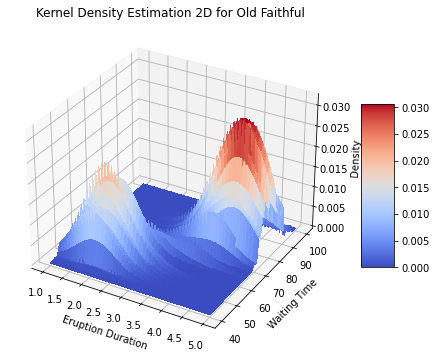

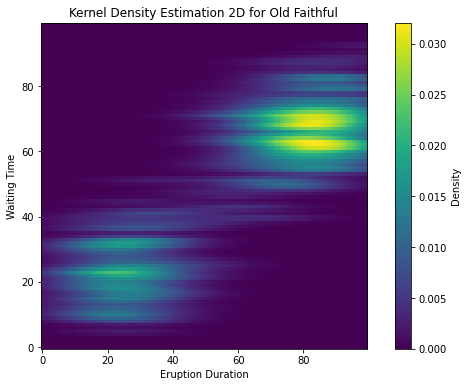

In [14]:
import seaborn as sns
from matplotlib import cm
faithful_data = sns.load_dataset("geyser")
data = faithful_data[['duration', 'waiting']].values



kde = KernelDensity(kernel='gaussian', bandwidth=0.5)

# Adapter le modèle aux données
kde.fit(data)

# Générer une grille 2D pour représenter la densité
x = np.linspace(1, 5, 100)
y = np.linspace(40, 100, 100)
x_grid, y_grid = np.meshgrid(x, y)
xy = np.column_stack([x_grid.ravel(), y_grid.ravel()])
log_dens = kde.score_samples(xy)
log_dens = log_dens.reshape(x_grid.shape)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, np.exp(log_dens), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("Eruption Duration")
ax.set_ylabel("Waiting Time")
ax.set_zlabel("Density")
ax.set_title("Kernel Density Estimation 2D for Old Faithful")
plt.show()


# Plot the density estimated as a heatmap using plt.imshow
plt.figure(figsize=(10, 6))
plt.imshow(np.exp(log_dens), origin='lower', cmap='viridis',)
plt.colorbar(label='Density')
plt.title("Kernel Density Estimation 2D for Old Faithful")
plt.xlabel("Eruption Duration")
plt.ylabel("Waiting Time")
plt.show()

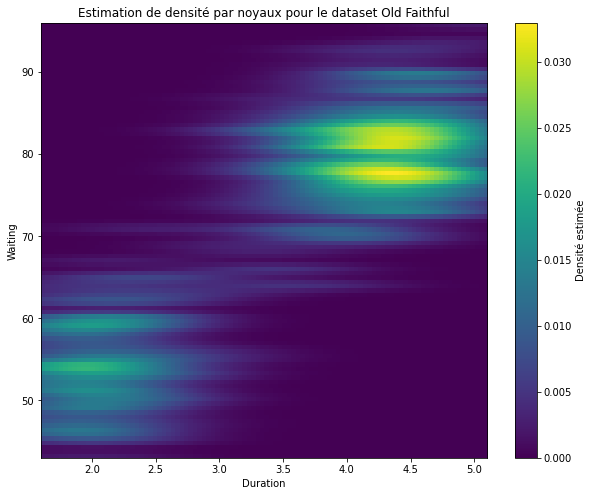

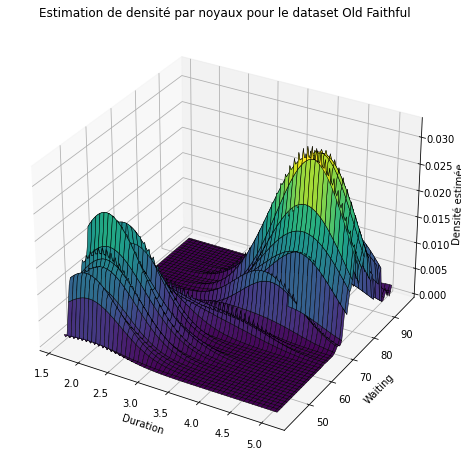

In [19]:
from sklearn.neighbors import KernelDensity
import seaborn as sns
import numpy as np

faithful_data = sns.load_dataset("geyser")
data = faithful_data[['duration', 'waiting']].values

# Créer une grille de points pour évaluer la densité
x = np.linspace(data[:, 0].min(), data[:, 0].max(), 100)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T

# Estimation de densité par noyaux avec un noyau gaussien et une largeur de fenêtre arbitraire
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)
log_density = kde.score_samples(xy_sample)
density = np.exp(log_density).reshape(X.shape)

# Visualisation de la densité sous forme de heatmap
plt.figure(figsize=(10, 8))
plt.imshow(density, origin='lower', aspect='auto', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis')
plt.colorbar(label='Densité estimée')
plt.xlabel('Duration')
plt.ylabel('Waiting')
plt.title('Estimation de densité par noyaux pour le dataset Old Faithful')
plt.show()

# Visualisation de la densité sous forme de surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, density, cmap='viridis', edgecolor='k', linewidth=0.5, antialiased=True)
ax.set_xlabel('Duration')
ax.set_ylabel('Waiting')
ax.set_zlabel('Densité estimée')
ax.set_title('Estimation de densité par noyaux pour le dataset Old Faithful')
plt.show()

import plotly.graph_objects as go

# Créer le surface plot avec plotly
fig = go.Figure(data=[go.Surface(z=density, x=X, y=Y, colorscale='Viridis')])

# Configuration de l'affichage
fig.update_layout(title='Estimation de densité par noyaux pour le dataset Old Faithful',
                  scene=dict(xaxis_title='Duration',
                             yaxis_title='Waiting',
                             zaxis_title='Densité estimée'))

fig.show()



---- Votre réponse ici ----

### Partie 4 : Estimation par noyaux (en 64D !) -- Un modèle génératif

Une fois la fonction de densité estimée par noyaux, nous pouvons facilement échantillonner de cette loi. Ceci nous permet donc de générer "de fausses données". C'est ce que nous allons mettre en oeuvre sur un exemple simple avec des images. Estimer la densité nous permettra donc de créer un générateur d'images.

**Q1 (bonus)**. Dans le cas d'un noyau gaussien, expliquer pourquoi il est facile d'échantillonner de la densité estimée.

> Si nous avons bien estimé la desnité avec des noyeaux gaussiens, nosu connaissons leur paramètre et il est alors facile d'échantilloner des données en les utilisant. 

> L'échantillonnage à partir d'une densité estimée avec un noyau gaussien est simple car cette estimation est une somme de distributions normales centrées autour des points de données. Pour échantillonner, on choisit d'abord un point de données au hasard, puis on tire un échantillon d'une distribution normale centrée sur ce point avec une variance définie par la largeur de la fenêtre (h). Ainsi, nous utilisons la facilité d'échantillonnage de la distribution normale pour obtenir un échantillon de notre densité estimée.

**Q2.** Dans cette dernière partie, nous considérons le cas où nos données représentent des images. Nous utiliserons le dataset *Digits* qui contient environ 1700 imagettes en niveaux de gris de taille 8 par 8, qui peuvent donc être représentées comme des vecteurs de taille 64. Ces imagettes représentent des numéros scannés de codes postaux.

- Estimer par noyaux de la densité en utilisant `scikit-learn`. Le choix du noyau et de la longueur de fenêtre est laissé libre.
- Échantillonner 10 nouvelles images de la loi estimée. On utilisera $\texttt{kde.sample}$
- Afficher 10 images tirées du dataset, puis les 10 images générées. Commenter.

 

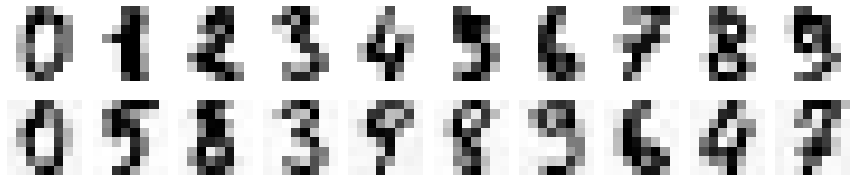

In [16]:
from sklearn.datasets import load_digits

X = load_digits().data

# Use scikit-learn to estimate the density
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)#0.5 was a bit messy
kde.fit(X)

# Generate 10 new samples
X_new = kde.sample(10)

# Plot 10 images from the dataset and 10 fake images obtained by sampling
fig, axes = plt.subplots(2, 10, figsize=(12, 3))   
for i in range(10):
    axes[0, i].imshow(X[i].reshape(8, 8), cmap='gray_r')
    axes[1, i].imshow(X_new[i].reshape(8, 8), cmap='gray_r')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


On arrive assez bien a identifié les chiffres.

> Certaines des images générées semblent reconnaissables comme des chiffres, tandis que d'autres ressemblent à des combinaisons de plusieurs chiffres originaux, ce qui est attendu car l'estimation par noyaux crée essentiellement une moyenne pondérée des images autour de chaque point de données.
>
> Le flou des images générées est influencé par le choix de la largeur de fenêtre (bandwidth). Une valeur différente pourrait rendre les images générées plus nettes ou plus floues.